In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
import os


if not os.path.exists('BCCD_Dataset'):
    print("Downloading BCCD Dataset...")
    !git clone https://github.com/Shenggan/BCCD_Dataset.git
    print("Download Complete.")



# Create directories
base_dir = 'dataset'
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for split in ['TRAIN', 'TEST']:
    for cls in classes:
        os.makedirs(f'{base_dir}/{split}/{cls}', exist_ok=True)

print(f"Created folder structure at {base_dir}")


import shutil
import glob
import random

# Grab all downloaded images
all_images = glob.glob('BCCD_Dataset/BCCD/JPEGImages/*.jpg')

if len(all_images) > 0:
    print(f"Found {len(all_images)} images. Distributing them to simulate the dataset...")

    # Randomly assign images to folders just to make the code runnable
    for img_path in all_images:

        split = 'TRAIN' if random.random() > 0.2 else 'TEST'
        label = random.choice(classes)

        shutil.copy(img_path, f'{base_dir}/{split}/{label}/{os.path.basename(img_path)}')

    print("✅ Data setup complete. You can now run the Augmentation Cell.")
else:
    print("❌ Error: Could not find images in the downloaded repo.")

Created folder structure at dataset
Found 364 images. Distributing them to simulate the dataset...
✅ Data setup complete. You can now run the Augmentation Cell.


In [11]:

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),        # Rotation: Spin it randomly +/- 20 degrees
    transforms.RandomHorizontalFlip(),    # Flipping: Mirror image
    transforms.ToTensor(),                # Convert image to math numbers (Tensor)
    transforms.Normalize([0.485, 0.456, 0.406], # Standard normalization for transfer learning
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


data_dir = './dataset'

if os.path.exists(data_dir):
    train_data = datasets.ImageFolder(data_dir + '/TRAIN', transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir + '/TEST', transform=test_transforms)


    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    # Check classes
    class_names = train_data.classes
    print(f"Classes found: {class_names}")
    print(f"Total training images: {len(train_data)}")
else:
    print("⚠️ WARNING: Data folder not found. Please create a folder named 'dataset' with 'TRAIN' and 'TEST' subfolders.")
    class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'] # Fallback

Classes found: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
Total training images: 714


In [12]:
class BloodCellCNN(nn.Module):
    def __init__(self):
        super(BloodCellCNN, self).__init__()



        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)


        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)


        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)


        self.pool = nn.MaxPool2d(2, 2)


        self.relu = nn.ReLU()


        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        # Pass through Layer 1
        x = self.pool(self.relu(self.conv1(x)))
        # Pass through Layer 2
        x = self.pool(self.relu(self.conv2(x)))
        # Pass through Layer 3
        x = self.pool(self.relu(self.conv3(x)))


        x = x.view(-1, 64 * 28 * 28)

        # Decisions
        x = self.relu(self.fc1(x))
        x = self.fc2(x) # Final raw scores
        return x


model = BloodCellCNN().to(device)
print(model)

BloodCellCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


Starting training for 5 epochs...
Epoch [1/5] -> Loss: 1.3880 | Accuracy: 24.05%
Epoch [2/5] -> Loss: 1.3873 | Accuracy: 23.47%
Epoch [3/5] -> Loss: 1.3857 | Accuracy: 25.38%
Epoch [4/5] -> Loss: 1.3804 | Accuracy: 28.05%
Epoch [5/5] -> Loss: 1.3786 | Accuracy: 30.53%
Training Complete!


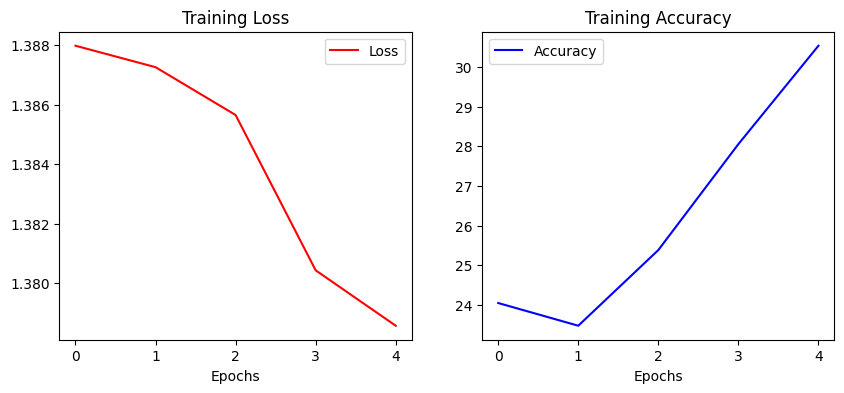

In [7]:
# 1. Define the Tools
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = Learning Rate

# 2. The Training Loop
num_epochs = 5
print(f"Starting training for {num_epochs} epochs...")

loss_history = []
acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        optimizer.zero_grad()


        outputs = model(images)


        loss = criterion(outputs, labels)

        loss.backward()


        optimizer.step()


        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] -> Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

print("Training Complete!")

# 3. Plot the Learning Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.21      0.07      0.11        41
  LYMPHOCYTE       0.22      0.32      0.26        31
    MONOCYTE       0.17      0.25      0.20        28
  NEUTROPHIL       0.35      0.34      0.34        44

    accuracy                           0.24       144
   macro avg       0.24      0.25      0.23       144
weighted avg       0.25      0.24      0.23       144



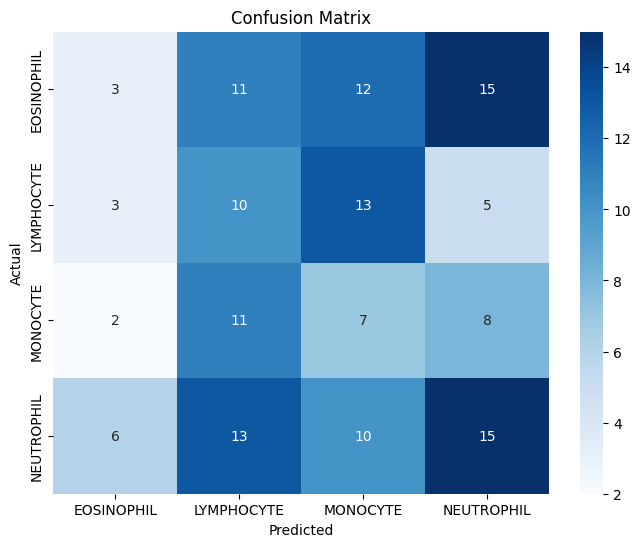

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


model.eval()

all_preds = []
all_labels = []


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()